# EMBS-BHI-2025: Robust and Reproducible AI Tutorial

Tutorial instructors: Ernest Namdar and Pascal Tyrrell

The dataset used in this tutorial and some of the codes are adopted from Openradiomics.
https://pubmed.ncbi.nlm.nih.gov/40760408/

This notebook explores how the train/test split ratio affects Random Forest AUROC performance.

## Setup
Import the required packages and configure deterministic seeds for reproducibility.

In [1]:
import os
import random
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from joblib import Parallel, delayed

SEED = 0
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
N_CORES = multiprocessing.cpu_count()
REPEATS = 100

In [2]:
# Comment out this cell if you run the code locally
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- Set working directory ---
import os

project_path = '/content/drive/MyDrive/EMBS_BHI_2025_Tutorial_Robust_and_Reproducible_AI/Part1-Classification/code'

# Change the working directory
os.chdir(project_path)

# Verify
print("Current working directory:", os.getcwd())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/EMBS_BHI_2025_Tutorial_Robust_and_Reproducible_AI/Part1-Classification/code


## Load and Prepare the Dataset
We read the radiomics dataset packaged with this tutorial and retain only the feature columns required for modelling.

In [3]:
DATA_PATH = '../data/Radiomics_NoNormalization_Whole_Tumor_T1CE.csv'

df = pd.read_csv(DATA_PATH)

In [4]:
df

,Lesion_ID,Group,Group_label,Patient_ID,Normalization,Subregion,Sequence,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,...,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength
0,1,LGG,0,BraTS20_Training_264,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,257.875481,0.002917,7.129410,0.068842,1.065569e+04,1.857225,0.001056,402.594060,0.057651,0.400334
1,2,LGG,0,BraTS20_Training_333,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,31400.796681,0.000034,9.194488,0.550131,5.733321e+00,0.037253,0.000198,615308.179535,0.086944,37.474497
2,3,LGG,0,BraTS20_Training_290,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,687.290391,0.001712,7.892693,0.031033,4.019240e+05,1.891263,0.000142,1546.563118,0.005046,0.767814
3,4,LGG,0,BraTS20_Training_269,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,14.038038,0.055507,5.427283,0.004712,1.996953e+06,34.988012,0.000462,11.145451,0.005164,0.024456
4,5,LGG,0,BraTS20_Training_263,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,799.617583,0.000725,7.988775,0.117867,5.486999e+03,0.454818,0.000960,2447.225716,0.047115,3.002776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,365,HGG,1,BraTS20_Training_207,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,250.731263,0.003331,7.412216,0.055957,3.441931e+04,2.054098,0.000544,586.352427,0.032293,0.458392
365,366,HGG,1,BraTS20_Training_192,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,994.351189,0.001169,7.464253,0.117230,3.670582e+04,2.321920,0.000186,2915.452880,0.036619,0.935791
366,367,HGG,1,BraTS20_Training_007,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,1122.955449,0.001012,7.625789,0.249371,2.043887e+03,0.674250,0.000442,8412.504297,0.069797,2.593628
367,368,HGG,1,BraTS20_Training_235,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,2511.604246,0.000511,8.163777,0.277927,3.428665e+03,1.032603,0.000163,17448.583739,0.088018,1.784128


In [5]:
y = df['Group_label']
X = df.drop(columns=[
    'Lesion_ID', 'Group', 'Group_label', 'Patient_ID',
    'Normalization', 'Subregion', 'Sequence'
] + [col for col in df.columns if col.startswith('diag')])

lb = LabelBinarizer()
y_bin = lb.fit_transform(y).ravel()

print('Feature matrix shape:', X.shape)
print('Label vector shape:', y.shape)

Feature matrix shape: (369, 1688)
Label vector shape: (369,)


There are 369 patients in the dataset (BraTS 2020) and 1688 radiomics features were extracted for each patient.

## Experiment Loop
We scan test ratios from 0.9 down to 0.1. For each ratio we repeat stratified train/test splits 100 times and record AUROC.

In [6]:
test_ratios = np.round(np.linspace(0.9, 0.1, 36), 2)
mean_aucs = []
min_aucs = []
max_aucs = []

def compute_auc(seed_offset, test_size):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_bin, test_size=test_size, random_state=SEED + seed_offset, stratify=y_bin
    )
    clf = RandomForestClassifier(random_state=SEED + seed_offset)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_prob)

for test_size in test_ratios:
    print(f'Evaluating test_size={test_size:.2f}')
    aucs = Parallel(n_jobs=N_CORES)(
        delayed(compute_auc)(i, test_size) for i in range(REPEATS)
    )
    mean_aucs.append(np.mean(aucs))
    min_aucs.append(np.min(aucs))
    max_aucs.append(np.max(aucs))

Evaluating test_size=0.90
Evaluating test_size=0.88
Evaluating test_size=0.85
Evaluating test_size=0.83
Evaluating test_size=0.81
Evaluating test_size=0.79
Evaluating test_size=0.76
Evaluating test_size=0.74
Evaluating test_size=0.72
Evaluating test_size=0.69
Evaluating test_size=0.67
Evaluating test_size=0.65
Evaluating test_size=0.63
Evaluating test_size=0.60
Evaluating test_size=0.58
Evaluating test_size=0.56
Evaluating test_size=0.53
Evaluating test_size=0.51
Evaluating test_size=0.49
Evaluating test_size=0.47
Evaluating test_size=0.44
Evaluating test_size=0.42
Evaluating test_size=0.40
Evaluating test_size=0.37
Evaluating test_size=0.35
Evaluating test_size=0.33
Evaluating test_size=0.31
Evaluating test_size=0.28
Evaluating test_size=0.26
Evaluating test_size=0.24
Evaluating test_size=0.21
Evaluating test_size=0.19
Evaluating test_size=0.17
Evaluating test_size=0.15
Evaluating test_size=0.12
Evaluating test_size=0.10


## Visualize AUROC vs Test Ratio
We plot the mean AUROC alongside the observed range, inverting the x-axis to emphasise larger training sets.

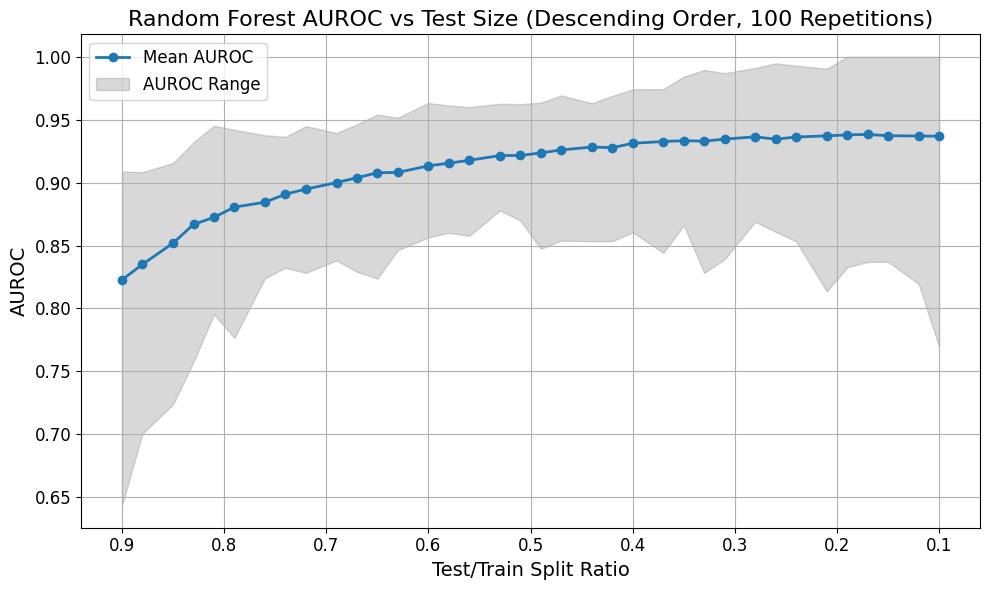

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(test_ratios, mean_aucs, marker='o', label='Mean AUROC', linewidth=2, markersize=6)
plt.fill_between(test_ratios, min_aucs, max_aucs, color='gray', alpha=0.3, label='AUROC Range')
plt.xlabel('Test/Train Split Ratio', fontsize=14)
plt.ylabel('AUROC', fontsize=14)
plt.title('Random Forest AUROC vs Test Size (Descending Order, 100 Repetitions)', fontsize=16)
plt.xticks(np.round(np.linspace(0.1, 0.9, 9), 2), fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_xaxis()
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## Tabular Summary
A quick dataframe summarises the central tendency and dispersion at each test ratio.

In [8]:
summary = pd.DataFrame({
    'test_ratio': test_ratios,
    'mean_auc': mean_aucs,
    'min_auc': min_aucs,
    'max_auc': max_aucs,
})
summary.head()

,test_ratio,mean_auc,min_auc,max_auc
0,0.90,0.822749,0.643555,0.908762
1,0.88,0.835014,0.700480,0.908278
2,0.85,0.851920,0.723818,0.915539
3,0.83,0.866764,0.757481,0.931987
4,0.81,0.872382,0.795325,0.945216


This is a dataset size sensitivity analysis and provides an insight for data sufficiency. Further study:
https://www.oncologyradiotherapy.com/articles/predicting-grade-of-oesophageal-squamous-carcinoma-canstretched-exponential-modelbased-dwi-perform-better-thanbiexponent.pdf